## Introduction

In this tutorial, I will build a model to predict the usefulness of Yelp Restaurant Reviews. 

On yelp.com, each restaurant can be given reviews by the customers. Each review can be marked useful, funny or cool. An assumption in this tutorial is, that I will only cover prediction of usefulness of a review; and that this is different than the 'funny-ness' and 'coolness' of the review.

The tutorial includes cleaning of data, exploratory data analysis, K-means clustering, Bag of Words model and Logistic regression. The objective is to find words used in reviews that increase the usefulness of the review. 

### Tutorial content

In this tutorial, I will show how to do some basic prediction analysis in Python.

I'll be using data collected from a Kaggle dataset downloaded from https://www.kaggle.com/yelp-dataset/yelp-dataset/data. This data contains information for over 5 million reviews posted on Yelp. 

I will cover the following topics in this tutorial:
- [Importing the libraries](#Importing-the-libraries)
- [Loading data and plotting](#Loading-data-and-plotting)
- [Bag of Words Model](#Bag-of-Words-Model)
- [K-Means Clustering of Reviews](#K-Means-Clustering-of-Reviews)
- [Logistic Regression with Top Cluster Words](#Logistic-Regression-with-Top-Cluster-Words)
- [Summary and references](#Summary-and-references)

## Importing the libraries

Before getting started, you'll need to install the various libraries that we will use. After you run all the installs, make sure the following commands work for you:

In [1]:
import io, time, json
import requests
import pandas as pd 
import string
import nltk
import numpy as np
import sklearn
import seaborn as sns
import scipy as scipy
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from collections import Counter
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix
from sklearn import grid_search, cross_validation, metrics
from sklearn.linear_model import LogisticRegression
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
%matplotlib inline

C:\Users\BKhus\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\BKhus\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


## Loading data and plotting

Now that we've installed and loaded the libraries, let's load our Yelp Reviews data.  We're going to load data provided in the "csv" format.

Download the `yelp_review.csv.zip` file from the Kaggle Yelp Data site: https://www.kaggle.com/yelp-dataset/yelp-dataset/data.  Then unzip the `yelp_review.csv.zip` file to create a `yelp_review.csv` folder with a number of files inside, including a `yelp_review.csv` file.  

The description of the dataset variables is as follows:

review_id: ID of the review | String

user_id: ID of the user | String

business_id: ID of the business | String

stars: Number of stars (rating between 1 and 5) this user gave this business | numeric

date: the date this review was written | DateTime

text: text of the review | String

useful: number of users who found the review useful | numeric

funny: number of users who found the review funny | numeric

cool: number of users who found the review cool | numeric

This is the csv we want. You can then load the data using the following command.

In [2]:
# read data into a DataFrame
data = pd.read_csv("yelp_review.csv")

The columns in the loaded data frame are:

In [3]:
list(data.columns.values)

['review_id',
 'user_id',
 'business_id',
 'stars',
 'date',
 'text',
 'useful',
 'funny',
 'cool']

The columns needed for this project are 'stars', 'text', 'useful', 'funny' and 'cool'.

In [4]:
# selecting the required columns
df1 = data.iloc[:, [3,5,6,7,8]]
df1.head()

,stars,text,useful,funny,cool
0,5,Super simple place but amazing nonetheless. It...,0,0,0
1,5,Small unassuming place that changes their menu...,0,0,0
2,5,Lester's is located in a beautiful neighborhoo...,0,0,0
3,4,Love coming here. Yes the place always needs t...,0,0,0
4,4,Had their chocolate almond croissant and it wa...,0,0,0


The number of data points and data types of columns can be found:

In [5]:
# Number of data points
df1['stars'].shape

# Data types of the columns
df1.dtypes

stars      int64
text      object
useful     int64
funny      int64
cool       int64
dtype: object

I now create a column 'tot' which represents the total number of users who responded to the review. Thus, this would be the sum of 'useful', 'funny' and 'cool' values.

In [6]:
#Create a column which counts total number of users that found the review useful/cool/funny
# Assumption: predicting only usefulness, not cool or funny.
df1['tot'] =  df1[['useful', 'funny', 'cool']].sum(axis=1)

C:\Users\BKhus\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


For the prediction model to be more accurate, I include reviews that have more than 50 total users who responded to the review only. This ensures that only data points that are more valuable are counted for faster analysis.

In [7]:
df1 = df1[(df1.tot > 50)]
df1['stars'].shape

(13520,)

Considering only the reviews that have more than 50 users that responded to the review, reduces the data points from 5261668 to 13520. The first 10 datapoints are:

In [8]:
df1.head(10)

,stars,text,useful,funny,cool,tot
536,1,"Dear Macayo's, \n\nI would like to thank you f...",14,29,14,57
546,5,Cafe Monarch is everything the five star revie...,25,19,12,56
568,3,"I'm a non-traditional girlfriend, so I always ...",15,27,24,66
574,4,"When I hit a quarter of a century in years, I ...",19,20,14,53
2438,1,I was very disappointed with this place. I was...,27,21,11,59
4255,5,Great food!\n\nThis restaurant isn't located o...,47,25,40,112
4259,5,Welcome to Fabulous Las Vegas!\n\nLas Vegas ha...,33,20,35,88
4260,5,Delicious Ramen!\n\nRandomly found this place ...,35,19,35,89
4263,5,"Lunch at the Don's...\n\nWell, that's what it ...",28,18,23,69
4266,4,Taste of Las Vegas!\n\nWe visited on Thanksgiv...,30,14,30,74


Any missing values from the data should be removed. Thus, the check for missing values is as follows:

In [9]:
df1.isnull().sum()

stars     0
text      0
useful    0
funny     0
cool      0
tot       0
dtype: int64

There are no null values in the data. Thus, we can go ahead with further analysis. Let's start off with the Bag of Words model for the reviews.

## Bag of Words Model

First, I create labels for each review. I call this label as useful_binary. I assume that if the percentage of people who found it useful from the total number of people who responded to the review, is greater than 50%, then it is useful.

useful_binary = 1 for useful and 0 for not.

In [10]:
df1.loc[:, 'useful_binary'] = np.where(df1.loc[:, 'useful']/df1.loc[:, 'tot'] > 0.5, 1, 0)
print(df1.head(20))

       stars                                               text  useful  \
536        1  Dear Macayo's, \n\nI would like to thank you f...      14   
546        5  Cafe Monarch is everything the five star revie...      25   
568        3  I'm a non-traditional girlfriend, so I always ...      15   
574        4  When I hit a quarter of a century in years, I ...      19   
2438       1  I was very disappointed with this place. I was...      27   
4255       5  Great food!\n\nThis restaurant isn't located o...      47   
4259       5  Welcome to Fabulous Las Vegas!\n\nLas Vegas ha...      33   
4260       5  Delicious Ramen!\n\nRandomly found this place ...      35   
4263       5  Lunch at the Don's...\n\nWell, that's what it ...      28   
4266       4  Taste of Las Vegas!\n\nWe visited on Thanksgiv...      30   
4267       4  Great Place, Yummy desserts!\n\nThis was my fi...      32   
4268       4  mmm! halo halo :)\n\nCame to this area on the ...      37   
4269       4  I know it's

I create a new dataframe by removing 'funny' and 'cool', as now we will deal with only 'useful'.

In [11]:
df2 = df1[['stars', 'text', 'useful', 'tot', 'useful_binary']]

The number of values in each of the labels is given by:

In [12]:
df2['useful_binary'].value_counts()

0    11654
1     1866
Name: useful_binary, dtype: int64

Graphical representation of above:

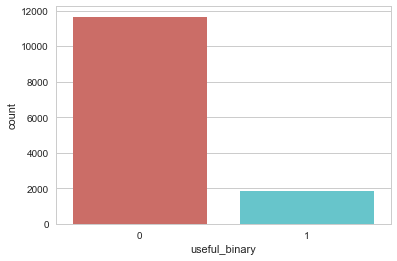

In [13]:
sns.countplot(x = 'useful_binary', data = df2, palette= 'hls')
plt.show()
plt.savefig('count_plot')

The means of the different values are for each of the labels:

In [14]:
df2.groupby('useful_binary').mean()

,stars,useful,tot
useful_binary,,,
0,4.004033,33.158143,90.254419
1,2.387460,83.649518,115.659164


In [15]:
df2.corr()

,stars,useful,tot,useful_binary
stars,1.000000,-0.192734,-0.085125,-0.424075
useful,-0.192734,1.000000,0.917421,0.269404
tot,-0.085125,0.917421,1.000000,0.082973
useful_binary,-0.424075,0.269404,0.082973,1.000000


From the correlation table, it can be seen that there is a small possibility of number of stars and useful_binary being related. Let's further analyze. 

In [16]:
#make a copy
df3 = df2.copy(deep = True)

First, I normalize the reviews (text) and handle punctuation. For this, use lemmatizer, an instance of a class implementing the lemmatize() method (the default argument is of type nltk.stem.wordnet.WordNetLemmatizer).

The following function returns tokenized text for any text that is passed to it. 

In [17]:
def process(text, lemmatizer=nltk.stem.wordnet.WordNetLemmatizer()):
    """ Normalizes case and handles punctuation
    Inputs:
        text: str: raw text
        lemmatizer: an instance of a class implementing the lemmatize() method
                    
    Outputs:
        list(str): tokenized text
    """
    
    #Reference: https://stackoverflow.com/questions/265960/best-way-to-strip-punctuation-from-a-string-in-python
    text = text.lower()    
    text= text.replace("'s","")    
    text= text.replace("'","")
    
    for c in string.punctuation:
        if (c in text):
            text= text.replace(c," ")    
    
    tokens = nltk.word_tokenize(text)
    tokenized_txt = []
    for token in tokens:
        tokenized_txt.append(lemmatizer.lemmatize(token))

    tokenized_txt = [str(t) for t in tokenized_txt]
    return tokenized_txt
    pass

Then, process all the reviews in the dataframe using the following code. The values of text column are changed from str to list(str). Each list contains all the words in a single review.

In [18]:
df3.text = df3.text.apply(lambda x: process(x))

To display the changed 'text' column:

In [19]:
print(df3.text.head())

536     [dear, macayo, i, would, like, to, thank, you,...
546     [cafe, monarch, is, everything, the, five, sta...
568     [im, a, non, traditional, girlfriend, so, i, a...
574     [when, i, hit, a, quarter, of, a, century, in,...
2438    [i, wa, very, disappointed, with, this, place,...
Name: text, dtype: object


The next step is to derive feature vectors from the tokenized reviews created in the previous step. 

As the number of possible words is very large and not all of them will add value to the classification task, I have to decide which words to retain, and which to omit. For this, I construct a frequency distribution of words and omit the words that have too many occurences and the words that have too less occurences, i.e., the head and the tail of the distribution. This is because very common words usually have very high occurences in sentences and don't add much value. Further, very rare words may be typos.

I use the list of in-built stop words provided by NLTK which can be used for the omission of very common words. The following  works on omission of very rare words. For this, if a word occurs not more than twice in whole of the reviews, then it is considered rare. 

In [20]:
#Reference: https://docs.python.org/2/library/collections.html#collections.Counter
list_of_words = []
for i in (df3['text']):   
    list_of_words.extend(i)
    
counter = Counter(list_of_words)
list_rare_words = [w for w in list_of_words if counter[w] == 2]


In [21]:
rare_words = sorted(list_rare_words)
print(len(rare_words))
print(rare_words)

13314
['021', '021', '036', '036', '0433eciexx6namw', '0433eciexx6namw', '05am', '05am', '092', '092', '0oquyisq', '0oquyisq', '0youckv6', '0youckv6', '1000x', '1000x', '100k', '100k', '100oz', '100oz', '1030', '1030', '1060', '1060', '10days', '10days', '10lbs', '10lbs', '10yrs', '10yrs', '113', '113', '1130', '1130', '114', '114', '11a', '11a', '11ish', '11ish', '11p', '11p', '11pts', '11pts', '121', '121', '1230', '1230', '1248', '1248', '128', '128', '1299', '1299', '12i0buxgq', '12i0buxgq', '12in', '12in', '12ish', '12ish', '136', '136', '13k', '13k', '142', '142', '14yr', '14yr', '15mins', '15mins', '164', '164', '16ish', '16ish', '1762', '1762', '179', '179', '1806', '1806', '186', '186', '1887', '1887', '189', '189', '18b', '18b', '1905', '1905', '1910', '1910', '1932', '1932', '1933', '1933', '1939', '1939', '1948', '1948', '1951', '1951', '1955', '1955', '1961', '1961', '1966', '1966', '1969', '1969', '1974', '1974', '1976', '1976', '1977', '1977', '199', '199', '1bimeepfc8qk

Now, I use the word count information across all the reviews to come up with a feature list. This creates a sparse matrix of features for each review with the help of sklearn.feature_extraction.text.TfidfVectorizer.

In [22]:
#creating features
stop_words_and_rare = nltk.corpus.stopwords.words('english') + rare_words
tfidf_vectorizer = sklearn.feature_extraction.text.TfidfVectorizer(stop_words = stop_words_and_rare)

df3.text = df3.text.apply(lambda x:' '.join(x))

X = tfidf_vectorizer.fit_transform(df3['text'])

In [23]:
print (X)

  (0, 11085)	0.0488374651785
  (0, 24216)	0.380184441716
  (0, 43754)	0.033181178788
  (0, 23433)	0.027178194837
  (0, 39475)	0.0325930393388
  (0, 32835)	0.07043797324
  (0, 18673)	0.136228427034
  (0, 5510)	0.117589014355
  (0, 3542)	0.122254346628
  (0, 6856)	0.0611271733141
  (0, 25418)	0.0793120437232
  (0, 15916)	0.0993485465648
  (0, 18313)	0.0421948388186
  (0, 14613)	0.0400255298251
  (0, 6182)	0.0385476262954
  (0, 11231)	0.0717488211846
  (0, 16326)	0.055580267329
  (0, 10241)	0.0428311934908
  (0, 35922)	0.0423491298659
  (0, 7171)	0.0195927610598
  (0, 24400)	0.0952643959907
  (0, 37791)	0.0344422234746
  (0, 11969)	0.0465836411914
  (0, 14914)	0.0288276996187
  (0, 33090)	0.0208545036502
  :	:
  (13519, 20862)	0.0772208124052
  (13519, 30347)	0.108392084849
  (13519, 3675)	0.0871420509096
  (13519, 25063)	0.0930345528845
  (13519, 28119)	0.0957760960746
  (13519, 2630)	0.104927987551
  (13519, 11466)	0.0922341024532
  (13519, 16206)	0.0999174386636
  (13519, 32247)	0.0756

Create a numpy array of the labels useful_binary for later use.

In [24]:
y = np.array(df3.useful_binary)
print(y)

[0 0 0 ..., 0 0 0]


For the classifier, I used sklearn.svm.SVC (Support Vector Machine). The following code learns a classifier from the input features and labels using the kernel function supplied.

In [25]:
kernel = 'linear'    
clf = SVC(kernel=kernel)
clf.fit(X, y) 

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

The following predicts the class using the learnt classifier. The decision function returns the decision function of the sample for each class in the model. The predict function performs classification on samples in X.

In [26]:
clf.decision_function(X)
clf.predict(X)

array([0, 0, 0, ..., 0, 0, 0])

The following code evaluates a classifier based on the validation data.

In [27]:
accuracy = accuracy_score(y, clf.predict(X))

print(accuracy)

0.954142011834


Thus, the accuracy using the bag of words model is 95.4%. Let's see if this accuracy can be made better using K-means and logistic regression

## K-Means Clustering of Reviews

The idea here is to find the most descriptive clusters to simplify the model.

First, apply TfidfVectorizer to review the text and fit the vectorizer to the text column. TF-IDF are word frequency scores that try to highlight words that are more interesting, e.g. frequent in a document but not across documents.

In [28]:
tfidf_vectorizer = sklearn.feature_extraction.text.TfidfVectorizer(stop_words = 'english')
tfidf_vectorizer.fit(df3['text'])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

Now, construct a sparse matrix of features for each review with the help of sklearn.feature_extraction.text.TfidfVectorizer. Further, learn the vocabulary using get_feature_names().

In [29]:
X_train = tfidf_vectorizer.transform(df3['text'])

vocab = tfidf_vectorizer.get_feature_names()
vocab = np.array(vocab)

Then, create the K-means model 'kmeans' with 2 clusters (pre-determined). Each observation is assigned to a cluster (cluster assignment) so as to minimize the within cluster sum of squares.  

In [30]:
sse_error = []
kmeans = KMeans(n_clusters=2, init='k-means++', max_iter=100, n_init=1,random_state=5)
kmeans.fit(X_train)
y_kmeans = kmeans.predict(X_train)

Find the number of observations in each cluster.

In [31]:
# how many observations are in each cluster
df3['cluster'] = kmeans.labels_
df3.groupby('cluster').count()

,stars,text,useful,tot,useful_binary
cluster,,,,,
0,7973,7973,7973,7973,7973
1,5547,5547,5547,5547,5547


The mean values of each of the columns for each of the clusters is given by:

In [32]:
df3.groupby('cluster').mean()

,stars,useful,tot,useful_binary
cluster,,,,
0,3.660605,40.826038,91.286843,0.199047
1,3.953849,39.121868,97.316568,0.050297


The top 10 words that are a part of each cluster are displayed by the following code:

In [33]:
#Reference: https://pythonprogramminglanguage.com/kmeans-text-clustering/
sorted_vals = kmeans.cluster_centers_.argsort()[:, ::-1]
words = []
for i in range(2):
    print("Cluster %d:" % i),
    for ind in sorted_vals[i, :10]:
        print(' %s' % vocab[ind]) 
        words.append(vocab[ind])

Cluster 0:
 wa
 time
 place
 like
 just
 dont
 great
 room
 im
 service
Cluster 1:
 wa
 food
 good
 place
 chicken
 sauce
 like
 restaurant
 menu
 order


It is seen that these words lie in each of the clusters. This could mean that, in each of these clusters, these might be the words used to predict the usefulness of the review. There are some top words that overlap among clusters like 'place' and 'like'. However, there doesn't seem to be a clear trend to the clusters. 

Let's further analyze this using Logistic Regression.

## Logistic Regression with Top Cluster Words

Firstly, let's add the top words to the training set. This is because these words will be the ones used for the prediction.

In [34]:
print (words)

['wa', 'time', 'place', 'like', 'just', 'dont', 'great', 'room', 'im', 'service', 'wa', 'food', 'good', 'place', 'chicken', 'sauce', 'like', 'restaurant', 'menu', 'order']


In [35]:
#add the top words to train set
training_set = X_train[:,[np.argwhere(vocab==i)[0][0] for i in words]]

Then, I add the 'stars' column to the training set sparse matrix. This is because we need an estimate of the stars that the users give the reviews that they find helpful.

In [36]:
stars = np.array(list(df3.stars))
stars = stars.reshape(13520, 1)

features = scipy.sparse.hstack((training_set,scipy.sparse.csr_matrix(stars)))

features = scipy.sparse.csr_matrix(features)

In [37]:
features.shape

(13520, 21)

In order to find the best logistic regression parameters, I use grid_search.GridSearchCV. GridSearchCV carries out an exhaustive search over specified parameter values for an estimator. Important members are fit and predicted. 

In [38]:
feature_set = features
gs = grid_search.GridSearchCV(
    estimator=LogisticRegression(),
    param_grid={'C': [10**-i for i in range(-5, 5)], 'class_weight': [None, 'balanced']},
    cv=cross_validation.StratifiedKFold(df3.useful_binary,n_folds=10),
    scoring='roc_auc'
)

gs.fit(features, df3.useful_binary)
gs.grid_scores_

[mean: 0.79124, std: 0.02968, params: {'C': 100000, 'class_weight': None},
 mean: 0.79213, std: 0.02973, params: {'C': 100000, 'class_weight': 'balanced'},
 mean: 0.79124, std: 0.02969, params: {'C': 10000, 'class_weight': None},
 mean: 0.79213, std: 0.02973, params: {'C': 10000, 'class_weight': 'balanced'},
 mean: 0.79123, std: 0.02971, params: {'C': 1000, 'class_weight': None},
 mean: 0.79213, std: 0.02973, params: {'C': 1000, 'class_weight': 'balanced'},
 mean: 0.79099, std: 0.02975, params: {'C': 100, 'class_weight': None},
 mean: 0.79207, std: 0.02976, params: {'C': 100, 'class_weight': 'balanced'},
 mean: 0.78906, std: 0.03034, params: {'C': 10, 'class_weight': None},
 mean: 0.79148, std: 0.03001, params: {'C': 10, 'class_weight': 'balanced'},
 mean: 0.77677, std: 0.03243, params: {'C': 1, 'class_weight': None},
 mean: 0.78558, std: 0.03176, params: {'C': 1, 'class_weight': 'balanced'},
 mean: 0.76257, std: 0.03312, params: {'C': 0.1, 'class_weight': None},
 mean: 0.76534, std: 0

The best_estimator_ gives the estimator that was chosen by the search, i.e. estimator which gave highest score (or smallest loss if specified) on the left out data.

In [39]:
print(gs.best_estimator_)

LogisticRegression(C=10000, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)


Now, call predict on the estimator with the best found parameters.

In [40]:
y_pred = gs.predict(feature_set)
# Coefficients represent the log-odds
print(gs.best_estimator_.coef_)
print(gs.best_estimator_.intercept_)

[[-0.6490082   3.49026112  0.44894565 -2.9378784  -0.63286343  1.94602447
   2.32087741 -1.46917771 -2.52990111  3.26464099 -0.6490082  -2.43476869
  -5.84107448  0.44894565 -5.03019282 -3.33279684 -2.9378784  -0.37545048
  -9.24766365 -7.66699436 -0.6836618 ]]
[ 2.65809974]


Call predict_proba on the estimator with the best found parameters and then plot the roc curve. The ROC curve is created by plotting the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings. 

The accuracy is measured by the area under the ROC curve. The greater the area, the better the accuracy.

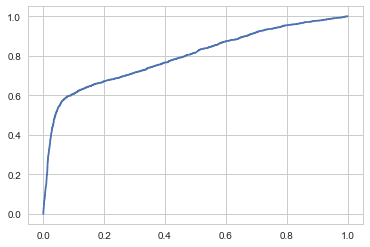

In [41]:
probas = gs.predict_proba(feature_set)
plt.plot(roc_curve(df3[['useful_binary']], probas[:,1])[0], roc_curve(df3[['useful_binary']], probas[:,1])[1])

In the following code, y_true is an array of the true values of useful_binary. y_score contains the predicted values. In order to find the accuracy, we use the roc_auc_score function to get the area under the curve. 

In [42]:
#roc auc score
y_score = probas
test2 = np.array(list(df3.useful_binary))
test2 = test2.reshape(13520,1)
y_true = test2

roc_auc_score(y_true, y_score[:,1].T)

0.79626412489002751

This accuracy of 79.6% is much lower than that we got from the bag of words model.

Now, combine the top words got from bag of words model. For each of the words, I display the best estimator coefficient. The larger the coefficient, the greater the chance that it is used to predict the usefulness of the review. 

In [43]:
#view top parameters
words.extend(['stars'])
sorted(zip(words,gs.best_estimator_.coef_[0]),key=lambda x:x[1])

[('menu', -9.2476636450389549),
 ('order', -7.6669943622522947),
 ('good', -5.8410744764178313),
 ('chicken', -5.0301928178637532),
 ('sauce', -3.3327968412123936),
 ('like', -2.9378783978349232),
 ('like', -2.9378783978349232),
 ('im', -2.5299011060910646),
 ('food', -2.4347686896460643),
 ('room', -1.4691777130807058),
 ('stars', -0.68366180455918391),
 ('wa', -0.64900820068324538),
 ('wa', -0.64900820068324538),
 ('just', -0.63286342973866316),
 ('restaurant', -0.37545047730119202),
 ('place', 0.44894565159738248),
 ('place', 0.44894565159738248),
 ('dont', 1.9460244668392885),
 ('great', 2.3208774085137609),
 ('service', 3.2646409916151962),
 ('time', 3.4902611235484251)]

From the above, it can be seen that words like 'dont', 'great', 'service', 'menu', 'order', 'good' have high coefficients. Thus, if these words are present in a review, there is a higher chance that it would be easily predicted as useful or not useful. For the other words, it cannot be predicted with high confidence. 

Further, the Bag-of-Words model had a higher accuracy than logistic regression. 

## Summary and references

This tutorial highlighted how we can predict the usefulness of Yelp reviews. It covers only some methods of predicting the usefulness. There can be further analysis which was out of scope for this tutorial. 

'service', 'great', 'time' are the top indicators of a useful review. This indicates a possible bias among customers to mark a review as useful when the review is positive, or when the review talks about the restaurant service and time.

Further resources:

Bag of Words Model tutorial:
https://machinelearningmastery.com/gentle-introduction-bag-words-model/

K-means clustering:
http://benalexkeen.com/k-means-clustering-in-python/

Logistic Regression:
https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8

Prediction models and text analytics:
https://www.analyticsvidhya.com/blog/2018/02/the-different-methods-deal-text-data-predictive-python/

Basic steps of building a prediction model:
https://www.analyticsvidhya.com/blog/2015/09/build-predictive-model-10-minutes-python/

References:
1. http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
2. https://machinelearningmastery.com/prepare-text-data-machine-learning-scikit-learn/
3. https://www.kaggle.com/waaaou/using-k-means-clustering-to-predict-helpfulness/notebook
4. https://pythonprogramminglanguage.com/kmeans-text-clustering/
5. http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
6. http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
7. http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
8. https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8
9. https://pythonprogramminglanguage.com/kmeans-text-clustering/
10. https://stackoverflow.com/questions/20113206/scikit-learn-svc-decision-function-and-predict